## Install libraries

In [14]:
! pip install feature_engine

   ---------------------------------------- 0.0/357.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/357.1 kB ? eta -:--:--
   - -------------------------------------- 10.2/357.1 kB ? eta -:--:--
   --- ----------------------------------- 30.7/357.1 kB 330.3 kB/s eta 0:00:01
   -------- ------------------------------ 81.9/357.1 kB 573.4 kB/s eta 0:00:01
   --------------------------- ------------ 245.8/357.1 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 357.1/357.1 kB 1.6 MB/s eta 0:00:00


### 1. Import Libraries

In [15]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

### 2. Display Settings

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
sklearn.set_config(transform_output="pandas")

In [7]:
warnings.filterwarnings("ignore")

### 3. Read the Data

In [8]:
file_path = r"C:\Users\Sameer_Subudhi\Desktop\Me\Research\ML\flight-price-prediction\data\train.csv"

train = pd.read_csv(file_path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-05-18,Delhi,Cochin,02:15:00,19:00:00,1005,1.0,No Info,15554
1,Air India,2019-03-24,Mumbai,Hyderabad,19:30:00,20:45:00,75,0.0,No Info,2575
2,Jet Airways,2019-03-24,Kolkata,Banglore,06:30:00,16:20:00,590,1.0,In-flight meal not included,8824
3,Air India,2019-03-03,Delhi,Cochin,07:05:00,19:15:00,2170,2.0,No Info,11762
4,Multiple Carriers,2019-03-03,Delhi,Cochin,10:20:00,01:35:00,915,1.0,No Info,15147
...,...,...,...,...,...,...,...,...,...,...
635,Air India,2019-05-06,Kolkata,Banglore,09:50:00,08:55:00,1385,2.0,No Info,13227
636,Air India,2019-03-03,Banglore,New Delhi,06:55:00,13:20:00,385,1.0,No Info,10924
637,Jet Airways,2019-05-21,Delhi,Cochin,05:30:00,19:00:00,810,2.0,In-flight meal not included,13029
638,Vistara,2019-06-01,Delhi,Cochin,14:40:00,17:50:00,190,0.0,No Info,6741


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
 9   price            640 non-null    int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 50.1+ KB


In [10]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

### 4. Transformation Operations

#### 4.1 airline

In [11]:
X_train.airline

0            Jet Airways
1              Air India
2            Jet Airways
3              Air India
4      Multiple Carriers
             ...        
635            Air India
636            Air India
637          Jet Airways
638              Vistara
639          Jet Airways
Name: airline, Length: 640, dtype: object

In [19]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]])#.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0
636,1.0,0.0,0.0,0.0,0.0
637,0.0,0.0,1.0,0.0,0.0
638,0.0,0.0,0.0,0.0,1.0


#### 4.2 date_of_journey

In [20]:
X_train.date_of_journey

0      2019-05-18
1      2019-03-24
2      2019-03-24
3      2019-03-03
4      2019-03-03
          ...    
635    2019-05-06
636    2019-03-03
637    2019-05-21
638    2019-06-01
639    2019-03-24
Name: date_of_journey, Length: 640, dtype: object

In [24]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,0.666667,0.647059,0.833333,0.661017
1,0.000000,0.176471,1.000000,0.194915
2,0.000000,0.176471,1.000000,0.194915
3,0.000000,0.000000,1.000000,0.016949
4,0.000000,0.000000,1.000000,0.016949
...,...,...,...,...
635,0.666667,0.588235,0.000000,0.559322
636,0.000000,0.000000,1.000000,0.016949
637,0.666667,0.705882,0.166667,0.686441
638,1.000000,0.764706,0.833333,0.779661


#### 4.3 source & destination

In [25]:
X_train.source

0         Delhi
1        Mumbai
2       Kolkata
3         Delhi
4         Delhi
         ...   
635     Kolkata
636    Banglore
637       Delhi
638       Delhi
639    Banglore
Name: source, Length: 640, dtype: object

In [26]:
X_train.destination

0         Cochin
1      Hyderabad
2       Banglore
3         Cochin
4         Cochin
         ...    
635     Banglore
636    New Delhi
637       Cochin
638       Cochin
639    New Delhi
Name: destination, Length: 640, dtype: object

In [27]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Mumbai,Hyderabad
2,Kolkata,Banglore
3,Delhi,Cochin
4,Delhi,Cochin
...,...,...
635,Kolkata,Banglore
636,Banglore,New Delhi
637,Delhi,Cochin
638,Delhi,Cochin


In [30]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,0.914151,0.917771
1,-1.900434,-1.037889
2,0.165876,0.162275
3,0.914151,0.917771
4,0.914151,0.917771
...,...,...
635,0.165876,0.162275
636,-1.092960,-1.037889
637,0.914151,0.917771
638,0.914151,0.917771


In [33]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [35]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)
    
FunctionTransformer(func=is_north).fit_transform(location_subset)    

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
635,1,0
636,0,1
637,1,0
638,1,0


In [36]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,0.914151,0.917771,1,0
1,-1.900434,-1.037889,1,0
2,0.165876,0.162275,1,0
3,0.914151,0.917771,1,0
4,0.914151,0.917771,1,0
...,...,...,...,...
635,0.165876,0.162275,1,0
636,-1.092960,-1.037889,0,1
637,0.914151,0.917771,1,0
638,0.914151,0.917771,1,0


#### 4.4 dep_time & arrival_time

In [39]:
X_train.dep_time

0      02:15:00
1      19:30:00
2      06:30:00
3      07:05:00
4      10:20:00
         ...   
635    09:50:00
636    06:55:00
637    05:30:00
638    14:40:00
639    11:10:00
Name: dep_time, Length: 640, dtype: object

In [40]:
X_train.arrival_time

0      19:00:00
1      20:45:00
2      16:20:00
3      19:15:00
4      01:35:00
         ...   
635    08:55:00
636    13:20:00
637    19:00:00
638    17:50:00
639    14:05:00
Name: arrival_time, Length: 640, dtype: object

In [41]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,02:15:00,19:00:00
1,19:30:00,20:45:00
2,06:30:00,16:20:00
3,07:05:00,19:15:00
4,10:20:00,01:35:00
...,...,...
635,09:50:00,08:55:00
636,06:55:00,13:20:00
637,05:30:00,19:00:00
638,14:40:00,17:50:00


In [44]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.086957,0.272727,0.826087,0.000000
1,0.826087,0.545455,0.869565,0.818182
2,0.260870,0.545455,0.695652,0.363636
3,0.304348,0.090909,0.826087,0.272727
4,0.434783,0.363636,0.043478,0.636364
...,...,...,...,...
635,0.391304,0.909091,0.347826,1.000000
636,0.260870,1.000000,0.565217,0.363636
637,0.217391,0.545455,0.826087,0.000000
638,0.608696,0.727273,0.739130,0.909091


In [49]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,evening
1,evening,night
2,morning,evening
3,morning,evening
4,morning,night
...,...,...
635,morning,morning
636,morning,afternoon
637,morning,evening
638,afternoon,evening


In [60]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.082609,0.772727
1,0.152174,0.663636
2,1.000000,0.772727
3,1.000000,0.772727
4,1.000000,0.663636
...,...,...
635,1.000000,1.000000
636,1.000000,0.000000
637,1.000000,0.772727
638,0.000000,0.772727


In [53]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.086957,0.272727,0.826087,0.000000,0.082609,0.772727
1,0.826087,0.545455,0.869565,0.818182,0.152174,0.663636
2,0.260870,0.545455,0.695652,0.363636,1.000000,0.772727
3,0.304348,0.090909,0.826087,0.272727,1.000000,0.772727
4,0.434783,0.363636,0.043478,0.636364,1.000000,0.663636
...,...,...,...,...,...,...
635,0.391304,0.909091,0.347826,1.000000,1.000000,1.000000
636,0.260870,1.000000,0.565217,0.363636,1.000000,0.000000
637,0.217391,0.545455,0.826087,0.000000,1.000000,0.772727
638,0.608696,0.727273,0.739130,0.909091,0.000000,0.772727


#### 4.5 duration

In [64]:
X_train.duration

0      1005
1        75
2       590
3      2170
4       915
       ... 
635    1385
636     385
637     810
638     190
639     175
Name: duration, Length: 640, dtype: int64

In [68]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	.shape
)

(3, 1)

In [73]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

In [74]:
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,5.573904e-07,1.000000,1.000000
1,0.000000e+00,0.000000e+00,0.904837,0.904837
2,0.000000e+00,0.000000e+00,1.000000,1.000000
3,0.000000e+00,0.000000e+00,0.904837,0.904837
4,0.000000e+00,0.000000e+00,1.000000,1.000000
...,...,...,...,...
635,0.000000e+00,0.000000e+00,0.904837,0.904837
636,3.257489e-70,0.000000e+00,1.000000,1.000000
637,0.000000e+00,0.000000e+00,0.904837,0.904837
638,0.000000e+00,0.000000e+00,0.904837,0.904837


In [78]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [80]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [81]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.391182,-0.13908,-0.097890,2.0,1,0.778772
1,-0.391182,-0.13908,-0.097890,0.0,0,-1.131156
2,-0.391182,-0.13908,-0.097890,2.0,0,-0.073508
3,-0.391182,-0.13908,-0.097890,2.0,1,2.847861
4,-0.391182,-0.13908,10.279028,2.0,0,0.593940
...,...,...,...,...,...,...
635,-0.391182,-0.13908,-0.097890,2.0,1,1.559173
636,-0.391182,-0.13908,-0.097890,1.0,0,-0.494513
637,-0.391182,-0.13908,-0.097890,2.0,0,0.378303
638,-0.391182,-0.13908,-0.097890,1.0,0,-0.894982


#### 4.6 total_stops

In [82]:
X_train.total_stops

0      1.0
1      0.0
2      1.0
3      2.0
4      1.0
      ... 
635    2.0
636    1.0
637    2.0
638    0.0
639    0.0
Name: total_stops, Length: 640, dtype: float64

In [84]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,1.0,0
1,0.0,1
2,1.0,0
3,2.0,0
4,1.0,0
...,...,...
635,2.0,0
636,1.0,0
637,2.0,0
638,0.0,1


#### 4.7 additional_info

In [85]:
X_train.additional_info

0                          No Info
1                          No Info
2      In-flight meal not included
3                          No Info
4                          No Info
                  ...             
635                        No Info
636                        No Info
637    In-flight meal not included
638                        No Info
639                        No Info
Name: additional_info, Length: 640, dtype: object

In [86]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
635,0.0,1.0,0.0
636,0.0,1.0,0.0
637,1.0,0.0,0.0
638,0.0,1.0,0.0


In [88]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [89]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [90]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
635,0.0,1.0,0.0,0
636,0.0,1.0,0.0,0
637,1.0,0.0,0.0,1
638,0.0,1.0,0.0,0


#### 4.8 Column Transformer

In [92]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,0.914151,0.917771,1,0,0.086957,0.272727,0.826087,0.000000,0.082609,0.772727,-0.391182,-0.13908,-0.097890,2.0,1,0.778772,1.0,0,0.0,1.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-1.900434,-1.037889,1,0,0.826087,0.545455,0.869565,0.818182,0.152174,0.663636,-0.391182,-0.13908,-0.097890,0.0,0,-1.131156,0.0,1,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,0.165876,0.162275,1,0,0.260870,0.545455,0.695652,0.363636,1.000000,0.772727,-0.391182,-0.13908,-0.097890,2.0,0,-0.073508,1.0,0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,0.914151,0.917771,1,0,0.304348,0.090909,0.826087,0.272727,1.000000,0.772727,-0.391182,-0.13908,-0.097890,2.0,1,2.847861,2.0,0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,1.000000,0.016949,0.914151,0.917771,1,0,0.434783,0.363636,0.043478,0.636364,1.000000,0.663636,-0.391182,-0.13908,10.279028,2.0,0,0.593940,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,1.0,0.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,0.165876,0.162275,1,0,0.391304,0.909091,0.347826,1.000000,1.000000,1.000000,-0.391182,-0.13908,-0.097890,2.0,1,1.559173,2.0,0,0.0,1.0,0.0,0
636,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.016949,-1.092960,-1.037889,0,1,0.260870,1.000000,0.565217,0.363636,1.000000,0.000000,-0.391182,-0.13908,-0.097890,1.0,0,-0.494513,1.0,0,0.0,1.0,0.0,0
637,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,0.914151,0.917771,1,0,0.217391,0.545455,0.826087,0.000000,1.000000,0.772727,-0.391182,-0.13908,-0.097890,2.0,0,0.378303,2.0,0,1.0,0.0,0.0,1
638,0.0,0.0,0.0,0.0,1.0,1.000000,0.764706,0.833333,0.779661,0.914151,0.917771,1,0,0.608696,0.727273,0.739130,0.909091,0.000000,0.772727,-0.391182,-0.13908,-0.097890,1.0,0,-0.894982,0.0,1,0.0,1.0,0.0,0


### 5. Feature Selection

In [93]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

### 6. Putting it all Together

In [94]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,0.0,1.0,0.647059,0.661017,0.914151,0.917771,-0.391182,2.0,1,0.778772,1.0,0
1,0.0,0.0,0.176471,0.194915,-1.900434,-1.037889,-0.391182,0.0,0,-1.131156,0.0,1
2,0.0,1.0,0.176471,0.194915,0.165876,0.162275,-0.391182,2.0,0,-0.073508,1.0,0
3,0.0,0.0,0.000000,0.016949,0.914151,0.917771,-0.391182,2.0,1,2.847861,2.0,0
4,0.0,0.0,0.000000,0.016949,0.914151,0.917771,-0.391182,2.0,0,0.593940,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
635,0.0,0.0,0.588235,0.559322,0.165876,0.162275,-0.391182,2.0,1,1.559173,2.0,0
636,0.0,0.0,0.000000,0.016949,-1.092960,-1.037889,-0.391182,1.0,0,-0.494513,1.0,0
637,0.0,1.0,0.705882,0.686441,0.914151,0.917771,-0.391182,2.0,0,0.378303,2.0,0
638,0.0,0.0,0.764706,0.779661,0.914151,0.917771,-0.391182,1.0,0,-0.894982,0.0,1


### 7. Visualizations

In [96]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': np.float64(-0.006605859653169214),
 'air__airline_Indigo': np.float64(0.13152527509866904),
 'air__airline_Jet Airways': np.float64(0.16677394343108354),
 'air__airline_Multiple Carriers': np.float64(0.014354416781134619),
 'air__airline_Other': np.float64(0.09841630271482112),
 'doj__date_of_journey_month': np.float64(0.08820186216021415),
 'doj__date_of_journey_week': np.float64(0.16017607884783933),
 'doj__date_of_journey_day_of_week': np.float64(-0.012587309987424855),
 'doj__date_of_journey_day_of_year': np.float64(0.2209242530404575),
 'location__source': np.float64(0.16854230861373273),
 'location__destination': np.float64(0.15171005938238905),
 'location__source_is_north': np.float64(0.0369287809957494),
 'location__destination_is_north': np.float64(0.0369287809957494),
 'time__dep_time_hour': np.float64(0.007724400518428931),
 'time__dep_time_minute': np.float64(-0.0017419895942082746),
 'time__arrival_time_hour': np.float64(0.04715287377265609),
 't

In [97]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'doj__date_of_journey_day_of_week': np.float64(-0.012587309987424855),
 'info__additional_info_In-flight meal not included': np.float64(-0.011480430290786344),
 'air__airline_Air India': np.float64(-0.006605859653169214),
 'info__additional_info_No Info': np.float64(-0.005845359578512658),
 'info__additional_info': np.float64(-0.005845359578512658),
 'dur__duration_rbf_50': np.float64(-0.00468262964207522),
 'time__dep_time_part_of_day': np.float64(-0.003941703649977184),
 'time__dep_time_minute': np.float64(-0.0017419895942082746),
 'dur__duration_rbf_75': np.float64(0.0015850774815063067),
 'time__dep_time_hour': np.float64(0.007724400518428931),
 'info__additional_info_Other': np.float64(0.009706888105294409),
 'air__airline_Multiple Carriers': np.float64(0.014354416781134619),
 'time__arrival_time_part_of_day': np.float64(0.023102534225314202),
 'location__source_is_north': np.float64(0.0369287809957494),
 'location__destination_is_north': np.float64(0.0369287809957494),
 'time__a

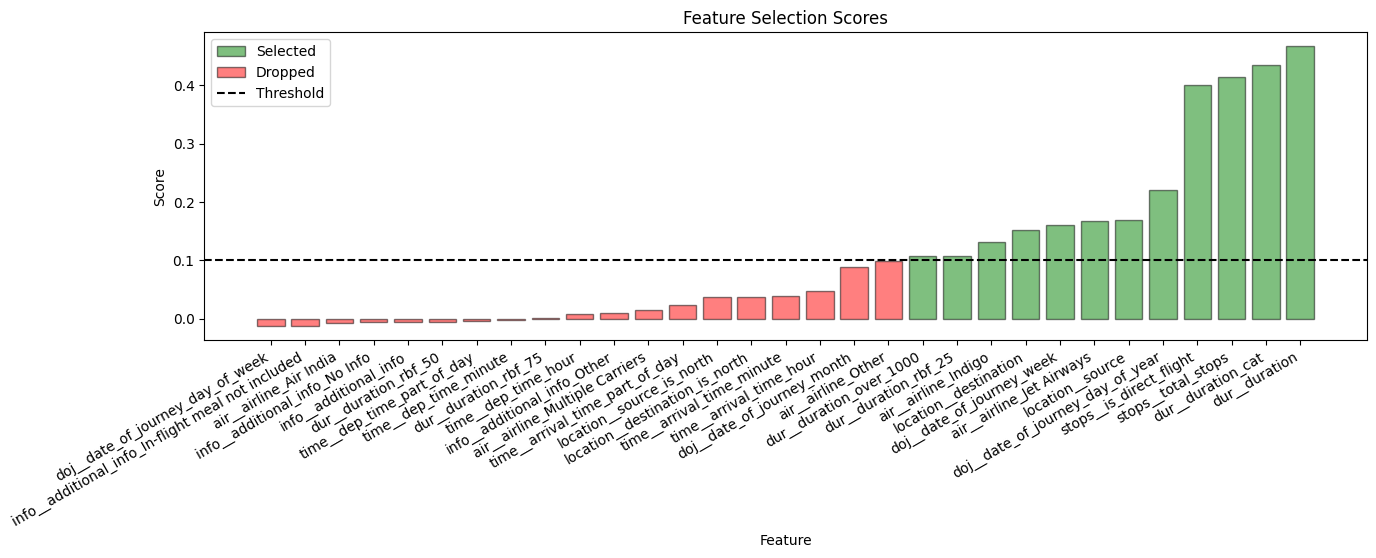

In [98]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()